<p style="font-family:Times;font-size:250%; text-align:center"> <font color='red'>Tugas 2 : RNN dengan ADAM</font></p>
<p style="font-family:Times;font-size:200%; text-align:center"> <font color='brown'>(oleh JOHANNES FELIX RIMBUN 13217006) </font></p>

In [4]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
#import seaborn as sb
#sb.set_theme()
#sb.set_style("whitegrid")
#sb.set_style("darkgrid")

%matplotlib inline

np.set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:6.5f}'.format})

#Sigmoid function & its derivative
sigmoid = lambda Z: 1/(1+exp(-Z))
dsigmoid = lambda A: A*(1-A)

#ReLU function & its derivative
ReLU  = lambda Z: Z.clip(0)
#Derivative of ReLU function
dReLU = lambda A: (A > 0)*1

#Derivativer of tanh()
dtanh = lambda A: 1-A**2

#Derivative oh arctanh
darctanh = lambda A: 1/(A**2+1)

#Softplus function & its derivative
splus = lambda Z: log(1+exp(Z))
dsplus = lambda A: 1/(1+exp(-A))

linear = lambda X,w,b: X@w+b

"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in arange(1,step+1):
        xt = hstack((xt, x[i:obs+i,:]))   
    return xt

Berikut ini adalah kelas RNN yang digunakan.
Terdapat beberapa modifikasi, yaitu sebagai berikut.
1. Penambahan variabel Mw0, Mb0, Mw1, Mb1, dan Mws untuk menyimpan nilai momen pertama dari turunan (i.e dCdw0, dCdb0, dst)
2. Penambahan variabel Vw0, Vb0, Vw1, Vb1, dan Vws untuk menyimpan nilai momen pertama dari turunan (i.e dCdw0, dCdb0, dst)
3. Kedua variabel M dan V ini di update setiap kali didapatkan nilai turunan yang baru.
4. Kemudian, dilakukan normalisasi bias terhap m dan w tersebut
5. Setelah didapatkan nilai yang sudah m dan w yang dinormalisasi, dihitung nilai parameter yang baru.

Pada pengerjaan ini, digunakan nilai beta1= 0.9 dan beta2=0.999

In [23]:
class RNN:
    def __init__(self,x,nh,alpha,epochs): # ada h nodes di dalam hidden layer  hlayers = [7, 3, 34, 89]
        self.Xtrain  = x #input
        self.ytrain  = x[:,-1:] #output     
        self.nh = nh   #number of neurons in hidden layer
        self.α  = alpha
        self.epochs = epochs
        self.Ts = shape(self.Xtrain)[1]-1   # Time-steps
        self.N, no = shape(self.ytrain)     #jumlah observasi (self.N) dan jumlah output
        self.ni    = 1  #jumlah input
        
        "Initial values untuk parameter w and b"
        seed(20201212)
        self.w0 = randn(self.ni,self.nh)
        self.b0 = randn(1,self.nh)
        self.w1 = randn(self.nh,no)
        self.b1 = randn(1,no)
        self.ws = randn(self.nh,self.nh)
        
        #inisiasi parameter momentum pertama untuk Adam
        self.Mw0=zeros([self.ni, self.nh])
        self.Mb0=zeros([1, self.nh])
        self.Mw1=zeros([self.nh, no])
        self.Mb1=zeros([1, no])
        self.Mws=zeros([self.nh, self.nh])
        
        #inisiasi parameter momentum kedua untuk Adam
        self.Vw0=zeros([self.ni, self.nh])
        self.Vb0=zeros([1, self.nh])
        self.Vw1=zeros([self.nh, no])
        self.Vb1=zeros([1, no])
        self.Vws=zeros([self.nh, self.nh])
    def learning(self):
        #inisiasi nilai beta sebagai parameter ADAM
        beta1=0.9
        beta2=0.999
        self.ycap = []
        for i in range(len(self.Xtrain)):
            self.S1 = [zeros((self.ni, self.nh))]  
            self.S2 = []              
            dCdw0 = zeros_like(self.w0)
            dCdb0 = zeros_like(self.b0)
            dCdw1 = zeros_like(self.w1)
            dCdb1 = zeros_like(self.b1)
            dCdws = zeros_like(self.ws)
            
            "Forward propagation in time step"
            for k in range(self.Ts):       
                A0 = self.Xtrain[i,k]
                yk = self.Xtrain[i,k + 1]
            
                # Forward pass, 1st layer
                Z1 = dot(A0,self.w0) + self.b0 + (self.S1[-1]@self.ws) 
                A1 = tanh(Z1)
                self.S1.append(copy(A1))   
            
                # Forward pass, 2nd layer
                Z2 = A1@self.w1 + self.b1
                A2 = sigmoid(Z2)
                self.S2.append(copy(A2))
                
            self.ycap.append(A2[0])
            
            "Backward propagation in time step"
            for k in arange(self.Ts)[::-1]:     
                A0 = self.Xtrain[i,k]
                yk = self.Xtrain[i,k + 1]
            
                # Backprop, 2nd layer
                dCdZ2 = -(yk - self.S2[k]) * dsigmoid(self.S2[k])
                dCdw1 += dot(self.S1[k+1].T,dCdZ2)
                dCdb1 += sum(dCdZ2)
            
                # Backprop, 1st layer
                dCdZ1 = dCdZ2@self.w1.T * dtanh(self.S1[k+1])
                dCdw0 += dot(A0, dCdZ1)
                dCdb0 += sum(dCdZ1)
            
                # Backprob, recurrent layer
                dCdws += dot(self.S1[k].T, dCdZ1)
            
            #Perhitungan momen pertama dan melakukan update
            self.Mw1=beta1*self.Mw1+(1-beta1)*dCdw1
            self.Mb1=beta1*self.Mb1+(1-beta1)*dCdb1
            self.Mw0=beta1*self.Mw0+(1-beta1)*dCdw0
            self.Mb0=beta1*self.Mb0+(1-beta1)*dCdb0
            self.Mws=beta1*self.Mws+(1-beta1)*dCdws
            
            #Perhitungan momen kedua dan melakukan update
            self.Vw1=beta1*self.Vw1+(1-beta1)*dCdw1**2
            self.Vb1=beta1*self.Vb1+(1-beta1)*dCdb1**2
            self.Vw0=beta1*self.Vw0+(1-beta1)*dCdw0**2
            self.Vb0=beta1*self.Vb0+(1-beta1)*dCdb0**2
            self.Vws=beta1*self.Vws+(1-beta1)*dCdws**2
            
            #Melakukan perbaikan bias pada momentum pertama
            mw1_hat=self.Mw1/(1-beta1**(i+1))
            mb1_hat=self.Mb1/(1-beta1**(i+1))
            mw0_hat=self.Mw0/(1-beta1**(i+1))
            mb0_hat=self.Mb0/(1-beta1**(i+1))
            mws_hat=self.Mws/(1-beta1**(i+1))
            
            #Melakukan perbaikan bias pada momentum kedua
            vw1_hat=self.Vw1/(1-beta2**(i+1))
            vb1_hat=self.Vb1/(1-beta2**(i+1))
            vw0_hat=self.Vw0/(1-beta2**(i+1))
            vb0_hat=self.Vb0/(1-beta2**(i+1))
            vws_hat=self.Vws/(1-beta2**(i+1))
            
            #Melakukanu pdate parameter berdasarkan nilai momentum yang telah diperbaiki
            self.w1 -= alpha * mw1_hat/(sqrt(vw1_hat)+1e-8)
            self.b1 -= alpha * mb1_hat/(sqrt(vb1_hat)+1e-8)
            self.w0 -= alpha * mw0_hat/(sqrt(vw0_hat)+1e-8)
            self.b0 -= alpha * mb0_hat/(sqrt(vb0_hat)+1e-8)
            self.ws -= alpha * mws_hat/(sqrt(vws_hat)+1e-8)


#### Implementasi RNN dengan ADAM untuk penaksiran harga saham

___

>Digunakan pergerakan harga saham pada Generals Motorsesuai dengan tugas 1

In [21]:
A  = pd.read_csv('GM.csv')  #Data time series harian harga saham Generals Motor
A6 = A['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = A6[:,newaxis]  
                                     
Bmin = min(B)
Bmax = max(B)
b = (B-Bmin)/(Bmax-Bmin)

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xs = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel 
x = xs[-800:,:]    #Ambil 800 observasi terakhir


#Data untuk training
Xtrain = x[0:680,:]   #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:680:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[680:, :]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[680:, -1:] #ambil kolom terakhir

#plt.plot(Xtrain, color = 'b')
#plt.show()

Epoch ke 0, SSE sebesar: 0.00444 dalam waktu 0:00:00.157585
Epoch ke 7, SSE sebesar: 0.00152 dalam waktu 0:00:01.053359
Epoch ke 14, SSE sebesar: 0.00146 dalam waktu 0:00:01.979461
Epoch ke 21, SSE sebesar: 0.00160 dalam waktu 0:00:02.884975
Epoch ke 28, SSE sebesar: 0.00146 dalam waktu 0:00:03.778921
Epoch ke 35, SSE sebesar: 0.00169 dalam waktu 0:00:04.955767


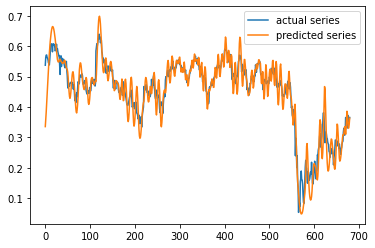

In [22]:
#Ringkasan nh = 3, alpha = 0.27 epochs = 36, ts = 1

nh     = 3  
alpha  = 0.27
epochs = 36

"Training"

rnn2 = RNN(Xtrain,nh,alpha,epochs)
tic = datetime.now()

for n in range(epochs):
    rnn2.learning()
    e = rnn2.ycap - ytrain
    sse = dot(e.T,e)/len(ytrain)
    toc = datetime.now()
            
    if n % ((epochs-1)/5) == 0:
        print(f"Epoch ke {n}, SSE sebesar: {sse[0][0]:6.5f} dalam waktu {datetime.now()-tic}")

#rnn = RNN(Xtrain,nh,alpha,epochs)
#rnn.training()

plt.plot(ytrain, label = 'actual series')
plt.plot(rnn2.ycap, label = 'predicted series')
plt.legend()
plt.show()

Pada data di atas, terlihat bahwa hasil prediksi dapat mengikuti nilai harga saham yang seharusnya. Dengan demikian, dapat dikatakan bahwa model RNN dengan ADAM ini berhasil diimplementasikan untuk pergerakan harga saham Generals Motor